In [26]:
# Cell 1: Imports and paths
from pathlib import Path
import json
import pandas as pd

DATA_DIR = Path("onepiece_episodes_json")
INDEX_FILE = DATA_DIR / "episodes_index.json"


In [27]:
# Cell 2: Load index
with INDEX_FILE.open(encoding="utf-8") as f:
    index = json.load(f)
index_df = pd.DataFrame(index)
index_df.head()


,episode_number,title,file,skipped
0,0,Episode 0,Episode_0.json,False
1,1,Episode 1,Episode_1.json,False
2,2,Episode 2,Episode_2.json,False
3,3,Episode 3,Episode_3.json,False
4,4,Episode 4,Episode_4.json,False


In [28]:
# Cell 3: Helpers to load/normalize a single episode file (pattern-based credits + character parsing)
import re

def extract_category_names(categories, prefix):
    """Return list of names from categories that start with prefix."""
    names = []
    for cat in categories:
        if cat.startswith(prefix):
            raw = cat[len(prefix):]
            names.append(raw.replace("_", " ").strip())
    return names

def first_or_none(seq):
    return seq[0] if seq else None

def parse_characters(text, lexicon=None):
    """
    Split character string into names.
    If lexicon is provided, use longest-match against known names.
    Otherwise, fallback to a 1–4 capitalized-token regex.
    """
    if not isinstance(text, str):
        return []
    if lexicon:
        tokens = text.split()
        out, i = [], 0
        # sort lexicon longest-first by token count, then length
        lex_sorted = sorted(lexicon, key=lambda n: (-len(n.split()), -len(n)))
        while i < len(tokens):
            match = None
            for name in lex_sorted:
                parts = name.split()
                if tokens[i:i + len(parts)] == parts:
                    match = name
                    break
            if match:
                out.append(match)
                i += len(match.split())
            else:
                i += 1  # skip unknown token
        return out
    # regex fallback (1–4 capitalized tokens, allow D., keep parens then strip)
    pattern = r"[A-Z][\w']+(?:\s(?:D\.|[A-Z][\w']+)){0,3}(?:\s\([^)]*\))?"
    names = re.findall(pattern, text)
    return [re.sub(r"\s*\([^)]*\)$", "", n) for n in names]

def load_episode(fp: Path, name_lexicon=None) -> dict:
    data = json.loads(fp.read_text(encoding="utf-8"))
    categories = data.get("categories") or []
    info = data.get("infobox") or {}
    items = info.get("items") or []

    # flatten infobox labels
    infobox_items = {item.get("label"): item.get("value_text") for item in items}

    def first_by_data_source(ds_name: str):
        for item in items:
            if item.get("data_source") == ds_name:
                return item.get("value_text")
        return None

    # credits parsed from category patterns (returns first match, but keeps list too)
    writers = extract_category_names(categories, "Episodes_Written_by_")
    art_directors = extract_category_names(categories, "Episodes_Art_Directed_by_")
    animators = extract_category_names(categories, "Episodes_Animated_by_")
    directors = extract_category_names(categories, "Episodes_Directed_by_")

    writer = first_or_none(writers)
    art_director = first_or_none(art_directors)
    animator = first_or_none(animators)
    director = first_or_none(directors)

    # arc name (pretty)
    arc_raw = next((c for c in categories if c.endswith("_Arc_Episodes")), None)
    arc_name = arc_raw.replace("_Arc_Episodes", "").replace("_", " ") if arc_raw else None

    # sections lookup
    sections = data.get("sections") or []
    def section_text(name):
        return next((s.get("text") for s in sections if s.get("heading") == name), None)

    chars_text = section_text("Characters in Order of Appearance")
    characters_list = parse_characters(chars_text, name_lexicon)

    return {
        "episode_number": data.get("episode_number"),
        "title": data.get("title"),
        "url": data.get("url"),
        "page_id": data.get("page_id"),
        "revid": data.get("revid"),
        "categories": categories,
        "infobox_title": info.get("title"),
        "kanji": infobox_items.get("Kanji"),
        "romaji": infobox_items.get("Romaji"),
        "airdate_str": infobox_items.get("Airdate"),
        "format": infobox_items.get("Format"),
        "tech": infobox_items.get("Tech"),
        "characters_infobox": infobox_items.get("Characters"),
        # pattern-extracted credits (single + list)
        "writer": writer,
        "art_director": art_director,
        "animator": animator,
        "director": director,
        "writers_all": writers,
        "art_directors_all": art_directors,
        "animators_all": animators,
        "directors_all": directors,
        # arc
        "arc_name": arc_name,   # e.g., "Romance Dawn"
        "arc_raw": arc_raw,
        # debut fields from data_source
        "char_debut": first_by_data_source("charDebut"),
        "tech_debut": first_by_data_source("techDebut"),
        # sections
        "short_summary": section_text("Short Summary"),
        "long_summary": section_text("Long Summary"),
        "characters_appearance": chars_text,
        "characters_list": characters_list,
        "raw_sections": sections,
        "raw_infobox_items": items,
    }


In [29]:
# Cell 4: Load all episodes into a DataFrame
episode_files = sorted(DATA_DIR.glob("Episode_*.json"))
records = [load_episode(fp) for fp in episode_files]
episodes_df = pd.DataFrame(records)
episodes_df.head()


,episode_number,title,url,page_id,revid,categories,infobox_title,kanji,romaji,airdate_str,...,arc_name,arc_raw,char_debut,tech_debut,short_summary,long_summary,characters_appearance,characters_list,raw_sections,raw_infobox_items
0,0,Episode 0,https://onepiece.fandom.com/wiki/Episode_0,33589,None,"[OVA, Episodes_Written_by_Jin_Tanaka, Episodes...",One Piece Film Strong World: Episode 0,ONE PIECE FILM STRONG WORLD: EPISODE 0,Wan Pīsu Firumu Sutorongu Wārudo Episōdo Zero,None,...,None,None,None,None,None,None,None,[],[],"[{'data_source': 'Kanji', 'label': 'Kanji', 'v..."
1,1,Episode 1,https://onepiece.fandom.com/wiki/Episode_1,4468,None,"[Episodes_Written_by_Junki_Takegami, Episodes_...",I'm Luffy! The Man Who Will Become the Pirate ...,俺はルフィ！海賊王になる男だ！,Ore wa Rufi! Kaizoku Ō ni naru Otoko da!,"October 20, 1999",...,Romance Dawn,Romance_Dawn_Arc_Episodes,"Gol D. Roger , Nami , Alvida , Koby , Heppoko ...","Luffy: Gomu Gomu no Rocket , Gomu Gomu no Pistol",Luffy is found floating at sea by a cruise shi...,Luffy is cast at sea in a barrel. Sailors on a...,Nami Alvida Koby Heppoko Peppoko Poppoko Monke...,"[Nami Alvida Koby Heppoko, Peppoko Poppoko Mon...","[{'heading': 'Short Summary', 'level': 2, 'htm...","[{'data_source': 'Kanji', 'label': 'Kanji', 'v..."
2,10,Episode 10,https://onepiece.fandom.com/wiki/Episode_10,5185,None,"[Episodes_Written_by_Junki_Takegami, Episodes_...",The World's Strongest Weirdo! Jango the Hypnot...,史上最強の変な奴！催眠術師ジャンゴ,Shijō saikyō no henna yatsu! Saiminjutsushi Jango,"January 19, 2000",...,Syrup Village,Syrup_Village_Arc_Episodes,Nugire Yainu,None,"Klahadore confronts the crew and Usopp , expel...","Klahadore confronts the crew , refusing their ...",Usopp Kaya Monkey D. Luffy Roronoa Zoro Tamane...,"[Usopp Kaya Monkey D., Luffy Roronoa Zoro Tama...","[{'heading': 'Short Summary', 'level': 2, 'htm...","[{'data_source': 'Kanji', 'label': 'Kanji', 'v..."
3,100,Episode 100,https://onepiece.fandom.com/wiki/Episode_100,11292,None,"[Episodes_Written_by_Junki_Takegami, Episodes_...",Rebel Warrior Koza! The Dream Sworn to Vivi!,反乱軍戦士コーザ！ビビに誓った夢！,Hanrangun senshi Kōza! Bibi ni chikatta yume!,"February 10, 2002",...,Arabasta,Arabasta_Arc_Episodes,"Toto , Aswa , Agotogi , Kebi , Natto",None,"The Straw Hats , Vivi and Ace are still travel...","The Straw Hats , Vivi and Ace are still travel...",Matsuge Nefertari Vivi Nami Monkey D. Luffy Us...,"[Matsuge Nefertari Vivi Nami, Monkey D. Luffy ...","[{'heading': 'Short Summary', 'level': 2, 'htm...","[{'data_source': 'Kanji', 'label': 'Kanji', 'v..."
4,1000,Episode 1000,https://onepiece.fandom.com/wiki/Episode_1000,331087,None,"[Episodes_Written_by_Shōji_Yonemura, Episodes_...",Overwhelming Strength! The Straw Hats Come Tog...,圧倒的戦力！麦わらの一味集結,Attōteki Senryoku! Mugiwara no Ichimi Shūketsu,"November 21, 2021",...,Wano Country,Wano_Country_Arc_Episodes,None,Usopp: Hisatsu Midori Boshi: Dokuro Bakuhatsu So,The Straw Hats reflect on their past adventure...,Big Mom rolls out of the castle and down the e...,Charlotte Linlin Charlotte Perospero Marco Sas...,"[Charlotte Linlin Charlotte Perospero, Marco S...","[{'heading': 'Short Summary', 'level': 2, 'htm...","[{'data_source': 'Kanji', 'label': 'Kanji', 'v..."


In [30]:
def build_name_lexicon(df):
    names = set()
    # from char_debut
    for txt in df["char_debut"].dropna():
        names.update(t.strip() for t in re.split(r"[;,\\n]", txt) if t.strip())
    # from characters_infobox
    for txt in df["characters_infobox"].dropna():
        names.update(t.strip() for t in re.split(r"[;,\\n]", txt) if t.strip())
    # from any section links, if present
    for sec_list in df["raw_sections"].dropna():
        for sec in sec_list:
            for link in sec.get("links") or []:
                if link.get("text"):
                    names.add(link["text"].strip())
    return names

# previous lexicon (global) kept for fallback if needed
lexicon = build_name_lexicon(episodes_df)

# Build characters_list using a running (cumulative) set of debuted characters.
# For each episode in episode-number order, include that episode's `char_debut`
# entries into the `seen` set (so debuts in the same episode are available
# to match appearances in that episode), then parse the appearance text
# using `parse_characters` with the running lexicon.

episodes_df = episodes_df.sort_values("episode_number").copy()
seen = set()
chars_running = []
for _, row in episodes_df.iterrows():
    # add char_debut names from this episode into seen
    txt = row.get("char_debut")
    if isinstance(txt, str):
        for name in (t.strip() for t in re.split(r"[,]", txt) if t.strip()):
            seen.add(name)

    # parse appearance string using the running lexicon (longest-match logic in parse_characters)
    parsed = parse_characters(row.get("characters_appearance"), lexicon=seen)
    chars_running.append(parsed)

# attach back to DataFrame in the same index order
episodes_df["characters_list"] = chars_running
print(episodes_df)


     episode_number         title  \
0                 0     Episode 0   
1                 1     Episode 1   
268               2     Episode 2   
379               3     Episode 3   
490               4     Episode 4   
..              ...           ...   
171            1151  Episode 1151   
172            1152  Episode 1152   
173            1153  Episode 1153   
174            1154  Episode 1154   
175            1155  Episode 1155   

                                               url  page_id revid  \
0       https://onepiece.fandom.com/wiki/Episode_0    33589  None   
1       https://onepiece.fandom.com/wiki/Episode_1     4468  None   
268     https://onepiece.fandom.com/wiki/Episode_2     4612  None   
379     https://onepiece.fandom.com/wiki/Episode_3     4613  None   
490     https://onepiece.fandom.com/wiki/Episode_4     5014  None   
..                                             ...      ...   ...   
171  https://onepiece.fandom.com/wiki/Episode_1151   353290  None   
172

In [31]:
# Cell 5: Basic cleaning/derived fields
episodes_df["airdate"] = pd.to_datetime(episodes_df["airdate_str"], errors="coerce")
episodes_df["year"] = episodes_df["airdate"].dt.year
episodes_df["month"] = episodes_df["airdate"].dt.to_period("M")
episodes_df["has_long_summary"] = episodes_df["long_summary"].notna()

# unpack categories into flags for easy grouping (e.g., arcs, seasons)
episodes_df["is_filler"] = episodes_df["categories"].apply(
    lambda cats: any("Filler" in c for c in cats)
)
episodes_df["season"] = episodes_df["categories"].apply(
    lambda cats: next((c.replace("Season_", "") for c in cats if c.startswith("Season_")), None)
)
episodes_df["arc"] = episodes_df["categories"].apply(
    lambda cats: next((c for c in cats if c.endswith("_Arc_Episodes")), None)
)


In [82]:
# Helpers: palette, arc bands, and count parsers
import seaborn as sns, matplotlib.pyplot as plt, re

sns.set_style("whitegrid")

unique_arcs = sorted(episodes_df["arc_name"].dropna().unique())
pastel = sns.color_palette("pastel", n_colors=max(3,12))
arc_palette = {arc: pastel[i % len(pastel)] for i, arc in enumerate(unique_arcs)}
import colorsys
import seaborn as sns

def clamp_lightness(rgb, lo=0.25, hi=0.70):
    h, l, s = colorsys.rgb_to_hls(*rgb)
    l = min(max(l, lo), hi)
    return colorsys.hls_to_rgb(h, l, s)

def shift(rgb, delta):
    h, l, s = colorsys.rgb_to_hls(*rgb)
    l = min(max(l + delta, 0), 1)
    return colorsys.hls_to_rgb(h, l, s)

def build_palettes(saga_def):
    saga_names = list(saga_def.keys())
    raw_base = sns.color_palette("tab20", n_colors=12)[:len(saga_names)]
    saga_base = {saga: clamp_lightness(raw_base[i]) for i, saga in enumerate(saga_names)}

    arc_palette = {}
    for saga, arcs in saga_def.items():
        n = max(1, len(arcs))
        base = saga_base[saga]
        dark = shift(base, -0.18)
        light = shift(base, +0.12)
        shades = sns.blend_palette([dark, base, light], n_colors=n, as_cmap=False)
        for arc, color in zip(arcs, shades):
            arc_palette[arc] = color
    return saga_base, arc_palette

def add_arc_bands(ax, df, xcol, show_legend=False, legend_mode='saga'):
    """Shade background by saga and color arcs within each saga as shades.

    Args:
        ax: matplotlib Axes
        df: DataFrame containing `arc_name` and xcol
        xcol: column name for x-axis values
        show_legend: whether to add a legend to the axes
        legend_mode: one of 'saga' (default), 'arc', or 'both' to control
                     which legend(s) are shown. When showing arc legend,
                     the order of arcs follows the `saga_def` ordering.
    """
    # Saga definitions (map saga -> list of arcs)
    saga_def = {
        "East Blue Saga": ["Romance Dawn", "Orange Town", "Syrup Village", "Baratie", "Arlong Park", "Loguetown"],
        "Arabasta Saga": ["Reverse Mountain", "Whisky Peak", "Little Garden", "Drum Island", "Arabasta"],
        "Sky Island Saga": ["Jaya", "Skypiea"],
        "Water 7 Saga": ["Long Ring Long Land", "Water 7", "Enies Lobby", "Post-Enies Lobby"],
        "Thriller Bark Saga": ["Thriller Bark"],
        "Summit War Saga": ["Sabaody Archipelago", "Amazon Lily", "Impel Down", "Marineford", "Post-War"],
        "Fish-Man Island Saga": ["Return to Sabaody", "Fish-Man Island"],
        "Dressrosa Saga": ["Punk Hazard", "Dressrosa"],
        "Whole Cake Island Saga": ["Zou", "Whole Cake Island", "Levely"],
        "Wano Country Saga": ["Wano Country"],
        "Final Saga": ["Egghead", "Elbaph"],
    }

    # Build arc -> saga mapping for fast lookup
    arc_to_saga = {}
    for saga, arcs in saga_def.items():
        for a in arcs:
            arc_to_saga[a] = saga

    # Choose base colors for sagas (qualitative palette)
    saga_names = list(saga_def.keys())
    saga_base, arc_palette_local = build_palettes(saga_def)

    # Use only the saga-derived arc palette so arcs not listed in saga_def
    # remain neutral (lightgray). Ignore any global `arc_palette` for
    # arcs that aren't part of saga_def to avoid unexpected colors.
    palette = arc_palette_local

    seen_sagas = set()
    seen_arcs = set()

    # Draw arc spans using per-arc colors (shades within saga)
    for arc, g in df.dropna(subset=["arc_name"]).groupby("arc_name"):
        x_start, x_end = g[xcol].min(), g[xcol].max()
        saga = arc_to_saga.get(arc)
        color = palette.get(arc, saga_base.get(saga, "lightgray"))
        # Only add per-arc labels if arc legend is requested
        label = arc if (legend_mode in ("arc", "both") and arc not in seen_arcs) else None
        ax.axvspan(
            x_start,
            x_end,
            color=color,
            alpha=0.45,
            lw=0,
            label=label,
        )
        seen_arcs.add(arc)
        if saga:
            seen_sagas.add(saga)

    if not show_legend:
        return

    # Build saga legend handles in defined order
    saga_handles = []
    saga_labels = []
    for saga in saga_names:
        if saga in seen_sagas:
            col = saga_base.get(saga, "lightgray")
            saga_handles.append(plt.Line2D([0], [0], color=col, lw=8, alpha=0.8))
            saga_labels.append(saga)

    # Build arc legend handles in saga/arc defined order
    arc_handles = []
    arc_labels = []
    if legend_mode in ("arc", "both"):
        for saga in saga_names:
            for arc in saga_def.get(saga, []):
                if arc in seen_arcs:
                    col = palette.get(arc, saga_base.get(saga, "lightgray"))
                    arc_handles.append(plt.Line2D([0], [0], color=col, lw=8, alpha=0.8))
                    arc_labels.append(arc)

    # Attach legends. Place legend(s) below the axes (centered).
    # Use bbox_to_anchor with a y < 0 to put the legend underneath the plot.
    # Adjust the numeric y values or call `plt.subplots_adjust(bottom=...)`
    # from the plotting code to make room when needed.
    saga_box = (0.5, -0.12)  # centered below the axes; tweak -0.12 as needed
    arc_box = (0.5, -0.32)   # further down when both legends are shown
    num_cols = 5
    if legend_mode == 'saga' and saga_handles:
        return ax.legend(saga_handles, saga_labels, title="Saga", bbox_to_anchor=saga_box, loc="upper center", ncol=num_cols)
    elif legend_mode == 'arc' and arc_handles:
        return ax.legend(arc_handles, arc_labels, title="Arc", bbox_to_anchor=saga_box, loc="upper center", ncol=num_cols)
    elif legend_mode == 'both':
        if saga_handles:
            lg1 = ax.legend(saga_handles, saga_labels, title="Saga", bbox_to_anchor=saga_box, loc="upper center", ncol=num_cols)
            ax.add_artist(lg1)
        if arc_handles:
            return ax.legend(arc_handles, arc_labels, title="Arc", bbox_to_anchor=arc_box, loc="upper center", ncol=num_cols)
def count_items(text):
    if not isinstance(text, str):
        return 0
    return len([t.strip() for t in re.split(r"[;,\\n]", text) if t.strip()])

def count_appearance(text):
    if not isinstance(text, str):
        return 0
    return len([t.strip() for t in re.split(r"[,\n]", text) if t.strip()])


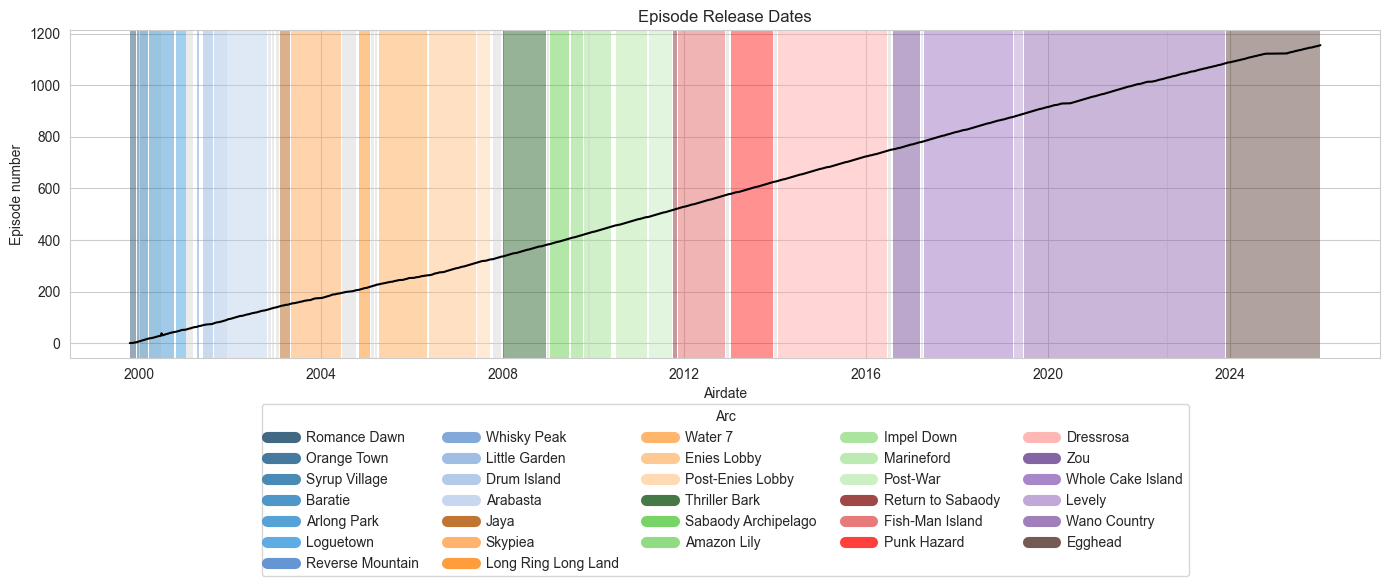

In [83]:
# Plot 1: Episode number over time (airdate), background by arc
plot1_df = episodes_df.dropna(subset=["airdate", "episode_number"]).sort_values("airdate")

fig, ax = plt.subplots(figsize=(14, 6))
# show arc legend (ordered)
add_arc_bands(ax, plot1_df, "airdate", show_legend=True, legend_mode='arc')

sns.lineplot(
    data=plot1_df,
    x="airdate",
    y="episode_number",
    color="black",
    linewidth=1.5,
    ax=ax,
    legend=False
)
ax.set(title="Episode Release Dates", xlabel="Airdate", ylabel="Episode number")
fig.subplots_adjust(bottom=0.28)
plt.tight_layout()
plt.show()


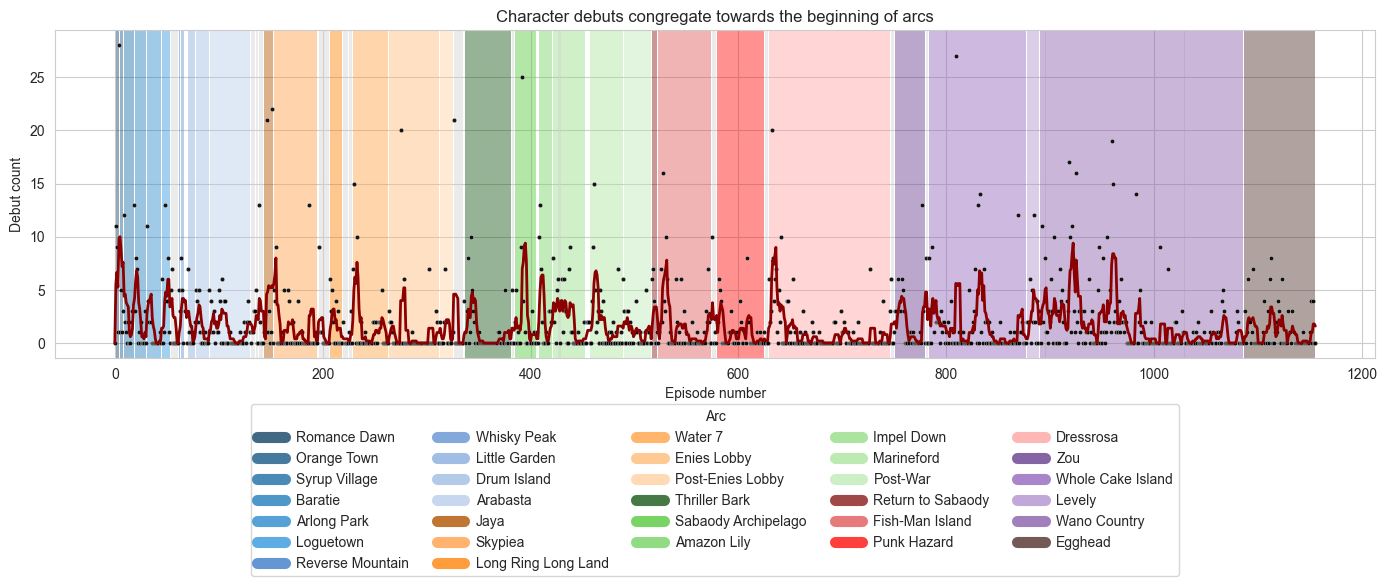

In [56]:
# Plot 2: Character debuts per episode (scatter + 10-episode rolling mean)
plot2_df = episodes_df.assign(char_debut_count=episodes_df["char_debut"].apply(count_items))
plot2_df = plot2_df.dropna(subset=["episode_number"]).sort_values("episode_number")
plot2_df["char_debut_roll10"] = plot2_df["char_debut_count"].rolling(window=5, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(14, 6))
add_arc_bands(ax, plot2_df, "episode_number", show_legend=True, legend_mode='arc')

sns.scatterplot(
    data=plot2_df,
    x="episode_number",
    y="char_debut_count",
    color="black",
    s=10,
    alpha=0.9,
    ax=ax,
    legend=False
)

line_obj, = ax.plot(
    plot2_df["episode_number"],
    plot2_df["char_debut_roll10"],
    color="darkred",
    linewidth=2,
    label="_nolegend_",
)

ax.set(title="Character debuts congregate towards the beginning of arcs", xlabel="Episode number", ylabel="Debut count")
fig.subplots_adjust(bottom=0.28)
plt.tight_layout()
plt.show()


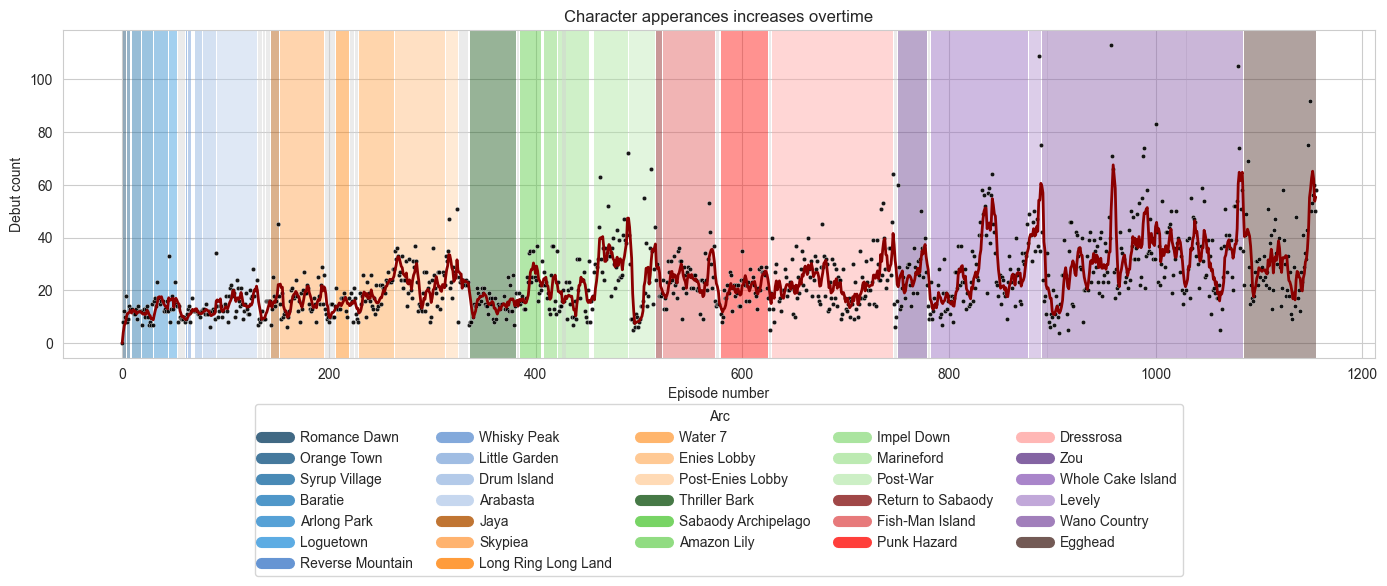

In [57]:
# Plot 3: Count of character appearances per episode (first section list), x = episode number
plot3_df = episodes_df.assign(appearance_count=episodes_df["characters_list"].apply(len))
plot3_df = plot3_df.dropna(subset=["episode_number"]).sort_values("episode_number")
plot3_df["char_appear_roll10"] = plot3_df["appearance_count"].rolling(window=5, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(14, 6))
add_arc_bands(ax, plot3_df, "episode_number", show_legend=True, legend_mode='arc')

sns.scatterplot(
    data=plot3_df,
    x="episode_number",
    y="appearance_count",
    color="black",
    s=10,
    alpha=0.9,
    ax=ax,
    label=None,
    legend=False
)

line_obj, = ax.plot(
    plot3_df["episode_number"],
    plot3_df["char_appear_roll10"],
    color="darkred",
    linewidth=2,
    label="_nolegend_",
)

ax.set(title="Character apperances increases overtime", xlabel="Episode number", ylabel="Debut count")
fig.subplots_adjust(bottom=0.28)
plt.tight_layout()
plt.show()


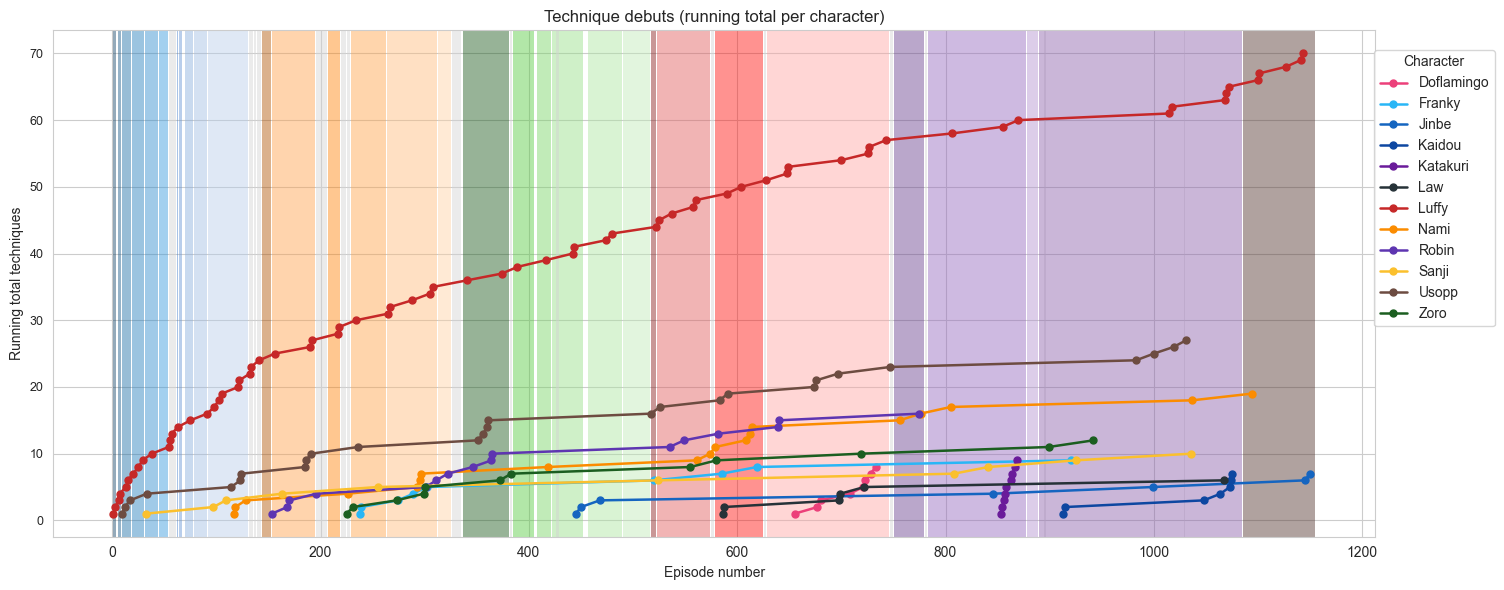

In [99]:
# Plot 4.5: Technique debuts — running total per character (x = episode number)

# explode technique debut strings into rows
tech_rows = []
for _, row in episodes_df.dropna(subset=["tech_debut"]).iterrows():
    ep = row["episode_number"]
    if pd.isna(ep):
        continue
    for item in [t.strip() for t in re.split(r"[;,\n]", row["tech_debut"]) if t.strip()]:
        m = re.match(r"([^:]+):\s*(.+)", item)
        if m:
            char, tech = m.group(1).strip(), m.group(2).strip()
        else:
            char, tech = "Unknown", item
            # print(f"Warning: could not parse technique debut item '{item}' in episode {ep}")
            continue
        tech_rows.append({"episode_number": ep, "arc_name": row["arc_name"], "character": char, "technique": tech})

tech_df = pd.DataFrame(tech_rows)
if tech_df.empty:
    print("No technique debut data to plot.")
else:
    # drop duplicate technique entries per character to avoid double-counting
    tech_df = tech_df.drop_duplicates(subset=["character", "technique", "episode_number"])
    tech_df = tech_df.sort_values("episode_number")
    tech_df["tech_running_total"] = tech_df.groupby("character").cumcount() + 1

    # optional: focus on top N characters by technique count to reduce clutter
    top_chars = tech_df["character"].value_counts().head(12).index
    tech_plot = tech_df[tech_df["character"].isin(top_chars)]

    # palette for characters
    char_palette = sns.color_palette("tab20", n_colors=len(top_chars))

    # optional explicit color overrides for characters (leave empty to use palette)
    # e.g. char_color_map = {"Monkey D. Luffy": "#e41a1c", "Roronoa Zoro": "#377eb8"}
    char_color_map = {
        "Luffy":     ["#C62828", "#F5D76E", "#2E2E2E"],   # red vest, straw hat, black hair
        "Zoro":      ["#1B5E20", "#B0BEC5", "#000000"],   # green hair, swords, black outfit
        "Nami":      ["#FB8C00", "#42A5F5", "#FDD835"],   # orange hair, blue motifs, gold
        "Usopp":     ["#6D4C41", "#8D6E63", "#FBC02D"],   # brown tones, goggles, yellow
        "Sanji":     ["#FBC02D", "#000000", "#1E88E5"],   # blond hair, black suit, blue shirt
        "Robin":     ["#5E35B1", "#212121", "#6D4C41"],   # dark purple, black, brown
        "Franky":    ["#29B6F6", "#E53935", "#FFD600"],   # cyan hair, red, bright yellow
        "Jinbe":     ["#1565C0", "#26A69A", "#0D47A1"],   # deep blue skin, teal, navy
        "Law":       ["#263238", "#FFFFFF", "#FBC02D"],   # dark coat, white hat, yellow emblem
        "Doflamingo":["#EC407A", "#FFFFFF", "#FDD835"],   # pink feathers, white, gold
        "Katakuri":  ["#6A1B9A", "#4E342E", "#AD1457"],   # purple scarf, brown, mochi tones
        "Kaidou":    ["#0D47A1", "#4A148C", "#263238"],   # blue dragon, purple, dark scales
    }

    fig, ax = plt.subplots(figsize=(14, 6))
    # show arc legend below the plot; keep the character legend at the right
    first_legend = add_arc_bands(
        ax,
        episodes_df.dropna(subset=["arc_name", "episode_number"]),
        "episode_number",
        show_legend=True,
        legend_mode='arc',
    )
    ax.add_artist(first_legend)
    char_handles = []
    char_labels = []
    for i, (char, g) in enumerate(tech_plot.groupby("character")):
        color = char_color_map.get(char, char_palette[i % len(char_palette)])[0]
        line, = ax.plot(
            g["episode_number"],
            g["tech_running_total"],
            marker="o",
            markersize=5,
            linewidth=1.8,
            label=None,
            color=color,
        )
        char_handles.append(line)
        char_labels.append(char)

    ax.set(
        title="Technique debuts (running total per character)",
        xlabel="Episode number",
        ylabel="Running total techniques",
    )

    # create character legend on the figure (handles first, labels second)
    if char_handles:
        lg = fig.legend(char_handles, char_labels, title="Character", bbox_to_anchor=(0.98, 0.92), loc="upper left")
        lg.set_zorder(30)
    ax.tick_params(axis="y", labelsize=9)
    # increase bottom space so the arc legend (below) and layout don't collide
    fig.subplots_adjust(bottom=0.32)
    plt.tight_layout()
    plt.show(),


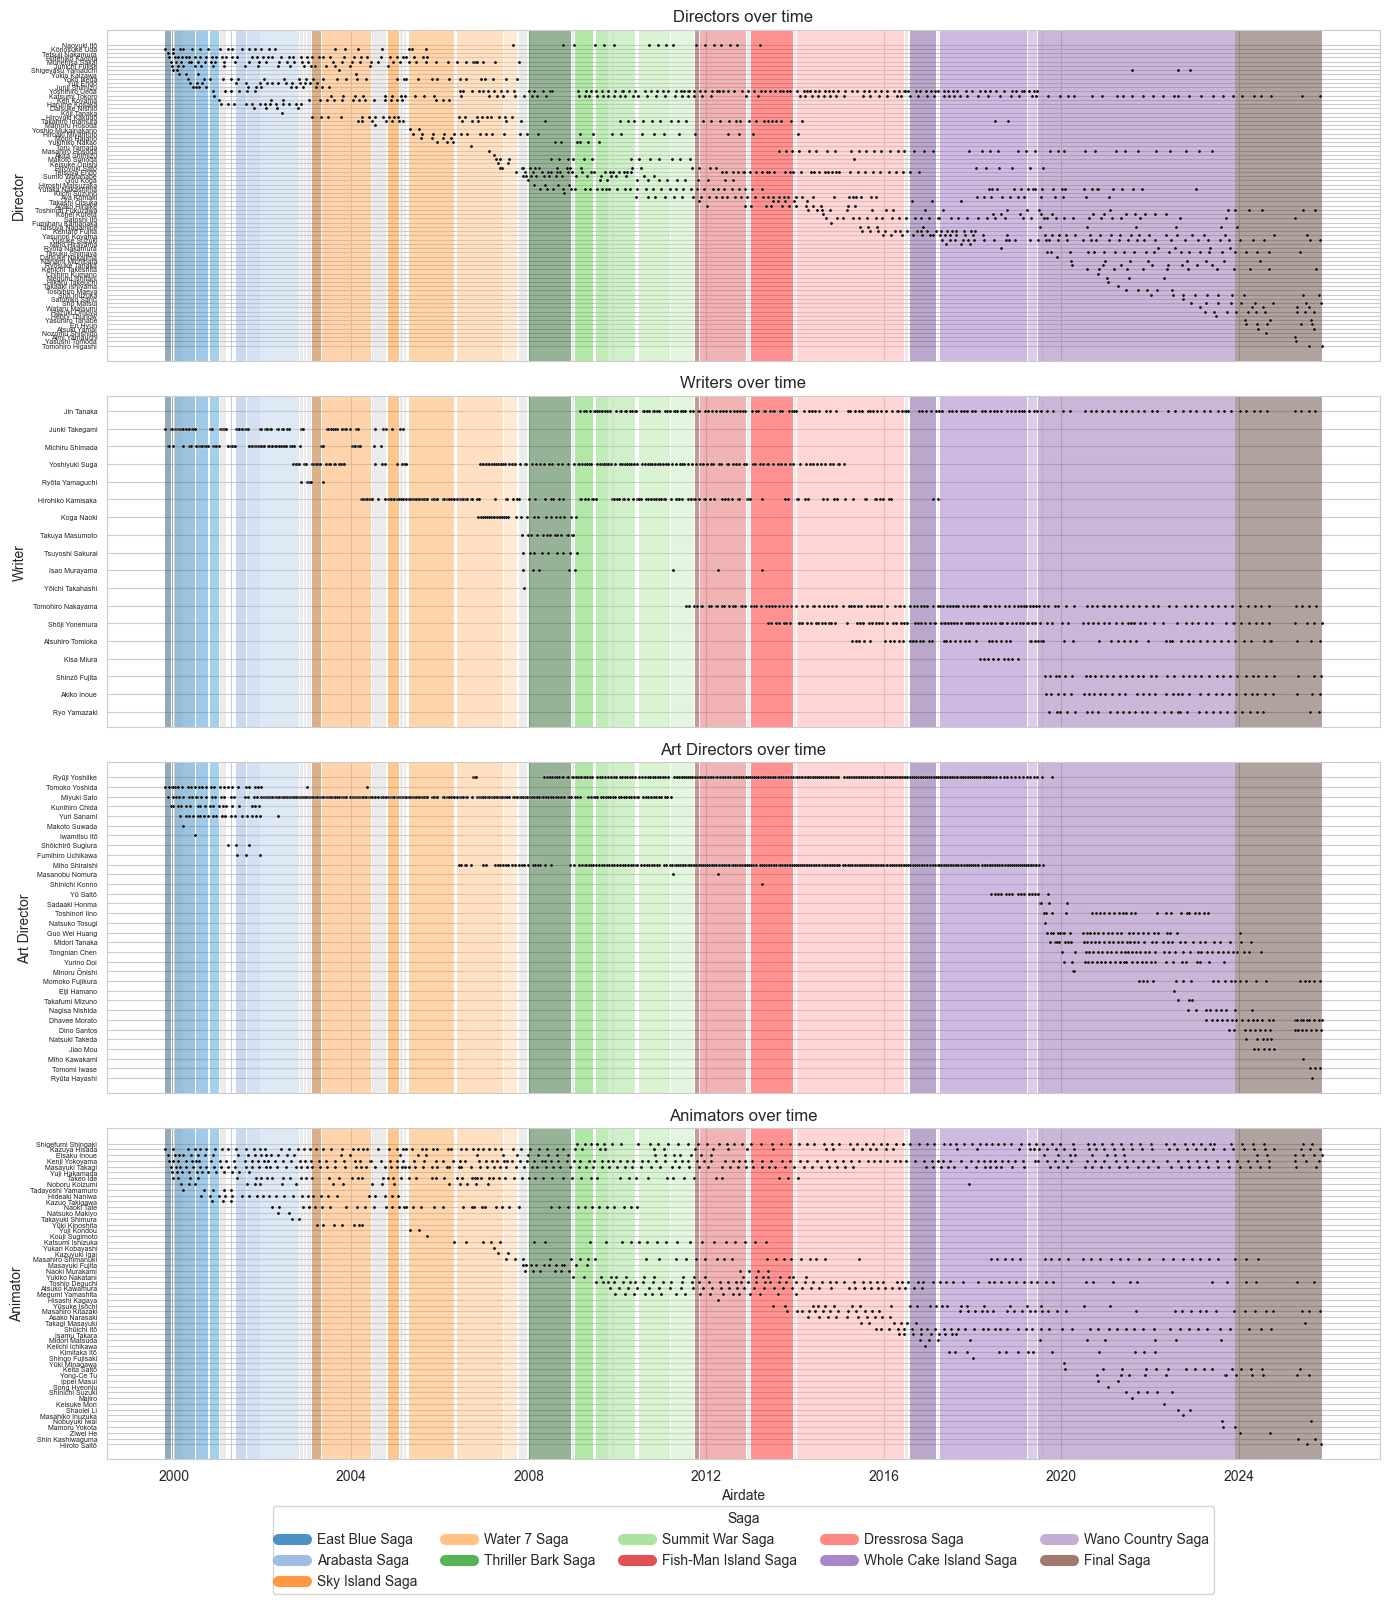

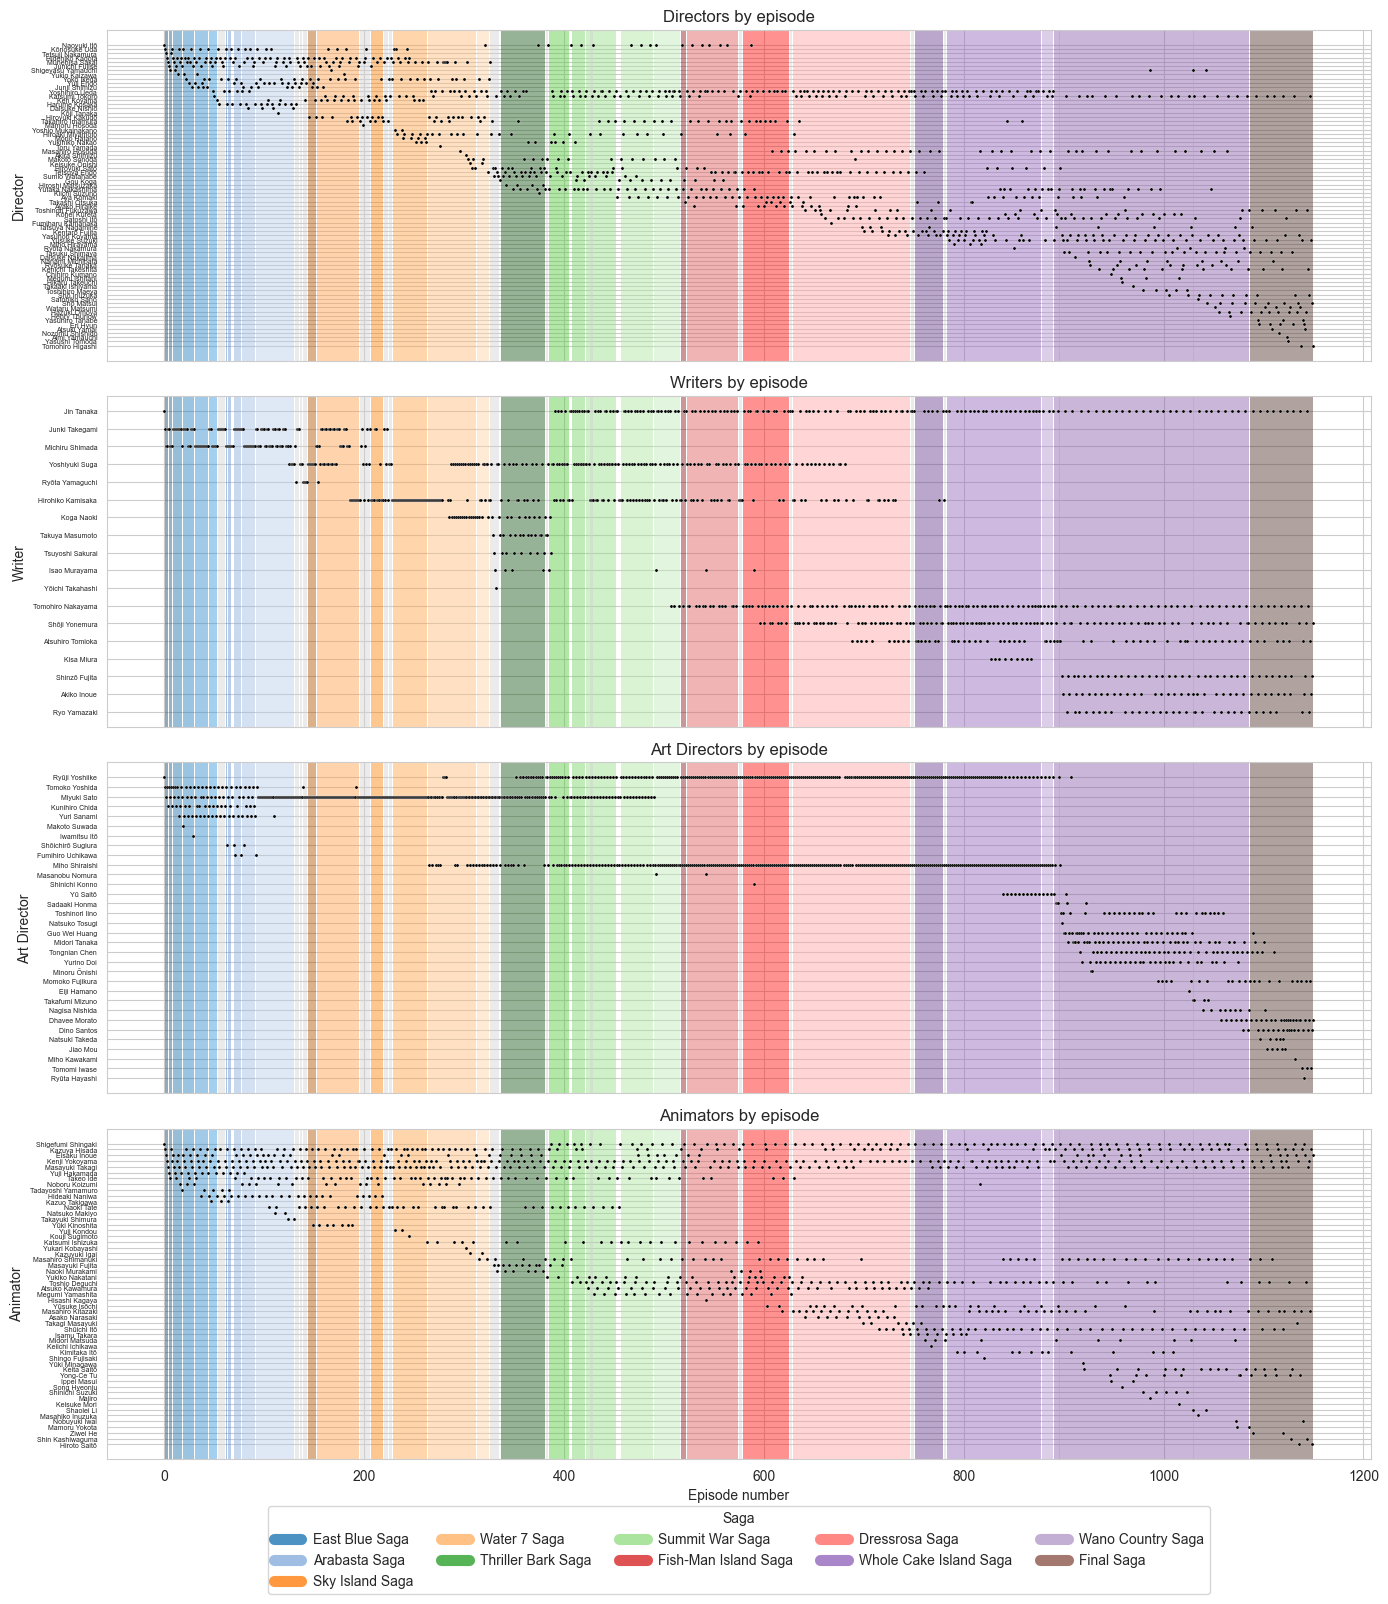

In [41]:
# Crew credits long-form
crew_roles = ["director", "writer", "art_director", "animator"]
crew_long = (
    episodes_df[["episode_number", "airdate", "arc_name"] + crew_roles]
    .melt(id_vars=["episode_number", "airdate", "arc_name"],
          var_name="role", value_name="person")
    .dropna(subset=["person"])
)

# Order people by first appearance so y-axis is stable
person_first_ep = (
    crew_long.dropna(subset=["episode_number"]) 
             .groupby("person")["episode_number"]
             .min()
             .sort_values()
             .index
)
crew_long["person"] = pd.Categorical(crew_long["person"], categories=person_first_ep, ordered=True)

crew_long["role"] = crew_long["role"].str.replace("_", " ").str.title()
role_order = ["Director", "Writer", "Art Director", "Animator"]

# Plot 4: crew by airdate
fig, axes_airdate = plt.subplots(len(role_order), 1, figsize=(14, 16), sharex=True)
for ax, role in zip(axes_airdate, role_order):
    sub = crew_long[(crew_long["role"] == role) & crew_long["airdate"].notna()].copy()
    sub["person"] = sub["person"].cat.remove_unused_categories()
    add_arc_bands(ax, sub, "airdate", show_legend=(role == role_order[-1]))
    sns.scatterplot(data=sub, x="airdate", y="person", color="black", s=5, ax=ax, legend=False)
    ax.set(title=f"{role}s over time", xlabel="Airdate", ylabel=role)
    ax.tick_params(axis="y", labelsize=5)   # adjust size here
fig.subplots_adjust(bottom=0.28)
plt.tight_layout()
plt.show()

# Plot 5: crew by episode number
fig, axes_episode = plt.subplots(len(role_order), 1, figsize=(14, 16), sharex=True)
for ax, role in zip(axes_episode, role_order):
    sub = (crew_long[(crew_long["role"] == role) & crew_long["episode_number"].notna()]
           .sort_values("episode_number")
           .copy())
    sub["person"] = sub["person"].cat.remove_unused_categories()
    add_arc_bands(ax, sub, "episode_number", show_legend=(role == role_order[-1]))
    sns.scatterplot(data=sub, x="episode_number", y="person", color="black", s=5, ax=ax, legend=False)
    ax.set(title=f"{role}s by episode", xlabel="Episode number", ylabel=role)
    ax.tick_params(axis="y", labelsize=5)   # adjust size here
fig.subplots_adjust(bottom=0.28)
plt.tight_layout()
plt.show()


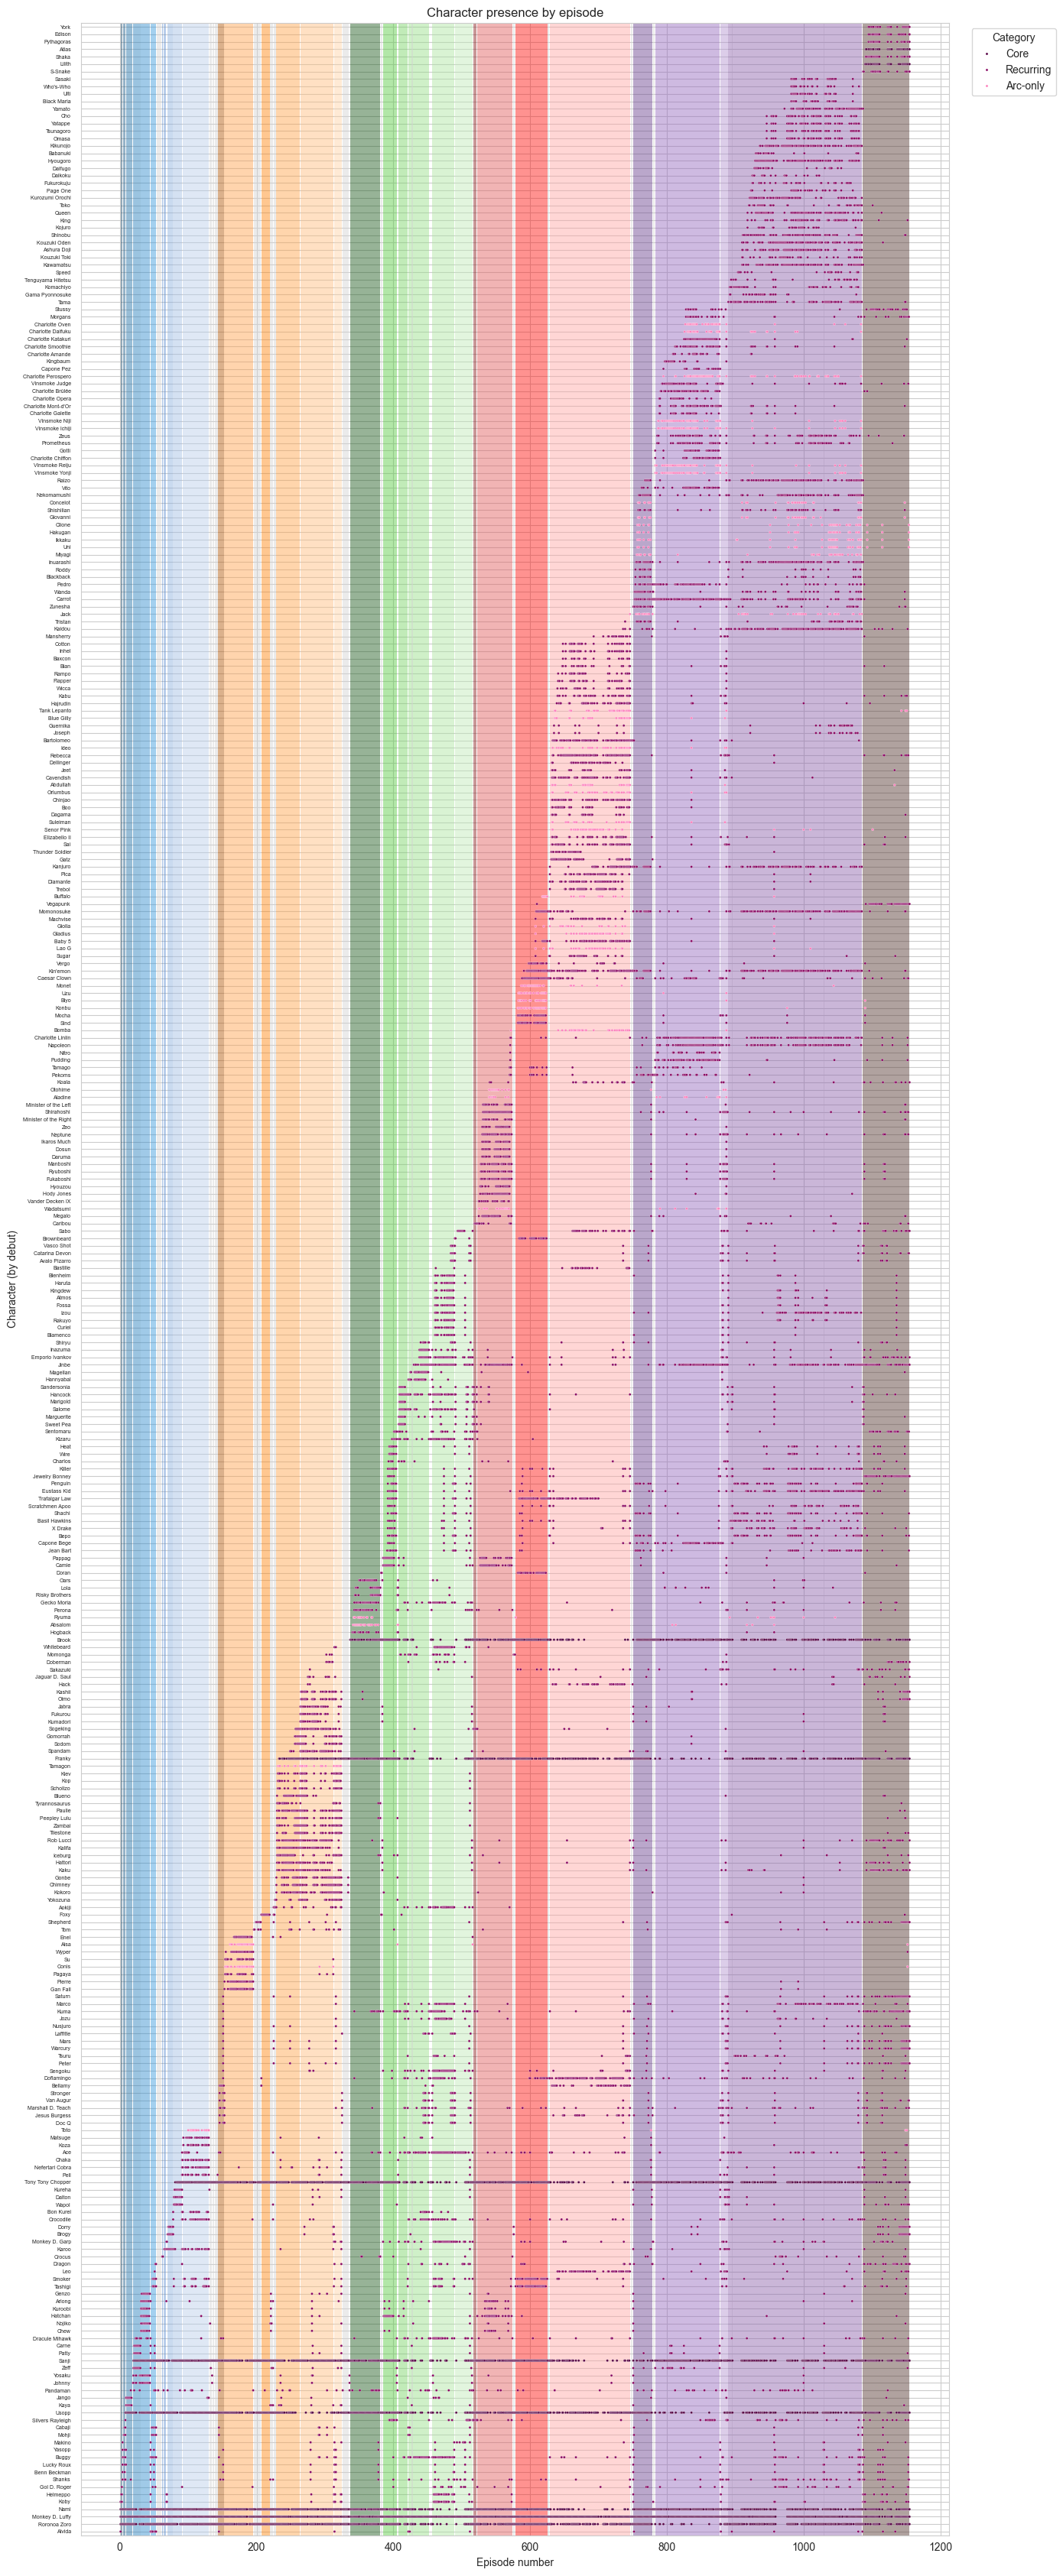

In [42]:
# Character–episode raster (debut-ordered, categorized)
appear = (
    episodes_df[["episode_number", "arc_name", "characters_list"]]
    .dropna(subset=["episode_number"])
    .explode("characters_list")
    .rename(columns={"characters_list": "character"})
    .dropna(subset=["character"])
)
k_min = 20  # set your threshold

appear_full = (
    episodes_df[["episode_number", "arc_name", "characters_list"]]
    .dropna(subset=["episode_number"])
    .explode("characters_list")
    .rename(columns={"characters_list": "character"})
    .dropna(subset=["character"])
)

counts = appear_full["character"].value_counts()
keep_chars = counts[counts >= k_min].index
appear = appear_full[appear_full["character"].isin(keep_chars)].copy()

# debut ordering
debut_ep = appear.groupby("character")["episode_number"].min()
appear["debut_ep"] = appear["character"].map(debut_ep)

# coverage since debut: fraction of episodes (from debut to max ep) they appear in
max_ep = episodes_df["episode_number"].max()
coverage = (appear.groupby("character")["episode_number"]
            .nunique() / (max_ep - debut_ep + 1))
# arc span count
arc_span = appear.groupby("character")["arc_name"].nunique()

def classify(char):
    if coverage[char] >= 0.50:      # core threshold
        return "Core"
    if arc_span[char] == 3:         # only ever in one arc
        return "Arc-only"
    return "Recurring"

appear["category"] = appear["character"].apply(classify)

# sort characters by debut
char_order = debut_ep.sort_values().index
appear["character"] = pd.Categorical(appear["character"], categories=char_order, ordered=True)

palette = {"Core": "#560244", "Arc-only": "#fd81bd", "Recurring": "#8a0963"}


fig, ax = plt.subplots(figsize=(14, max(8, len(char_order)*0.1)))
add_arc_bands(ax, episodes_df.dropna(subset=["arc_name", "episode_number"]), "episode_number",
              show_legend=True, legend_mode="saga")

sns.scatterplot(
    data=appear,
    x="episode_number",
    y="character",
    hue="category",
    palette=palette,
    s=5,
    ax=ax,
    legend="brief",
)
ax.margins(y=0)  # or y=0.01 if you want a hair of space
ax.set_ylim(-0.5, len(char_order) - 0.5)
ax.set(title="Character presence by episode", xlabel="Episode number", ylabel="Character (by debut)")
ax.tick_params(axis="y", labelsize=5,pad=6)
ax.legend(title="Category", bbox_to_anchor=(1.02, 1), loc="upper left")
fig.subplots_adjust(bottom=0.28)
plt.tight_layout()
plt.show()


In [54]:
# === Fast co-appearance graph with caching and sliders ===
import math, itertools
import numpy as np, pandas as pd, networkx as nx, plotly.graph_objects as go, plotly.express as px
from scipy import sparse
import ipywidgets as widgets
from itertools import chain

# Tunables
min_eps_node_default = 5
min_edge_co_default  = 10
edge_cap             = 5.0   # cap log-weight for layout forces
top_n_nodes          = 300   # cap nodes by episode count for layout speed (None to disable)
checkpoint_step      = 50    # build co-occ checkpoints every N episodes
edge_alpha           = 0.32
edge_w_a, edge_w_b   = 0.8, 0.6  # edge width = a + b*logw
node_base, node_scale = 2, 4.0  # node size = base + scale*log(eps)

# --- Precompute incidence matrix (episodes x characters) ---
eps_sorted = episodes_df.dropna(subset=["episode_number"]).sort_values("episode_number")
ep_ids = eps_sorted["episode_number"].to_numpy()
chars_series = eps_sorted["characters_list"].apply(lambda xs: xs or [])
all_chars = sorted({c for lst in chars_series for c in lst})
char_to_idx = {c: i for i, c in enumerate(all_chars)}

rows, cols, data = [], [], []
for r, chars in enumerate(chars_series):
    for c in chars:
        rows.append(r); cols.append(char_to_idx[c]); data.append(1)
A = sparse.coo_matrix((data, (rows, cols)), shape=(len(eps_sorted), len(all_chars))).tocsr()

# Prefix sums for node counts (episodes ≤ N)
prefix_counts = np.zeros((len(ep_ids)+1, A.shape[1]), dtype=np.int32)
prefix_counts[1:] = np.cumsum(A.toarray(), axis=0)  # OK for ~300 chars; adjust if larger

# Checkpoint co-occurrence (fast lookups for slider)
checkpoint_indices = list(range(0, len(ep_ids)+1, checkpoint_step))
if checkpoint_indices[-1] != len(ep_ids):
    checkpoint_indices.append(len(ep_ids))

co_checkpoints = []
for i in checkpoint_indices:
    Ai = A[:i]
    co = (Ai.T @ Ai).tocsr()
    co.setdiag(0)
    co.eliminate_zeros()
    co_checkpoints.append(co)

def co_for_prefix(n):
    # nearest checkpoint
    idx = max(i for i in checkpoint_indices if i <= n)
    base_co = co_checkpoints[checkpoint_indices.index(idx)].copy()
    if idx == n:
        return base_co
    # add remainder
    rem = A[idx:n]
    if rem.shape[0] > 0:
        delta = (rem.T @ rem).tocsr()
        delta.setdiag(0); delta.eliminate_zeros()
        base_co += delta
    base_co.eliminate_zeros()
    return base_co

# Global node totals
global_node_counts = prefix_counts[-1]

# Build base graph for layout/community (global weights)
def build_graph_from_co(co_mat, node_counts, min_eps_node, min_edge_co, top_n=None, ego=None):
    # filter nodes
    if top_n:
        top_idx = np.argsort(node_counts)[::-1][:top_n]
        keep_nodes = set(top_idx[node_counts[top_idx] >= min_eps_node])
    else:
        keep_nodes = {i for i, c in enumerate(node_counts) if c >= min_eps_node}
    # edges
    co_mat = co_mat.tocoo()
    edges = []
    for i, j, w in zip(co_mat.row, co_mat.col, co_mat.data):
        if i >= j:  # upper triangle only
            continue
        if i not in keep_nodes or j not in keep_nodes:
            continue
        if w < min_edge_co:
            continue
        logw = min(max(math.log1p(w), 1.0), edge_cap)
        edges.append((i, j, logw, w))
    G = nx.Graph()
    for i in keep_nodes:
        G.add_node(i, eps=node_counts[i], size=math.log1p(node_counts[i]))
    for i, j, logw, raw in edges:
        G.add_edge(i, j, weight=logw, raw=raw)
    if ego is not None and ego in char_to_idx:
        ego_idx = char_to_idx[ego]
        if ego_idx in G:
            nodes_keep = {ego_idx} | set(G.neighbors(ego_idx))
            G = G.subgraph(nodes_keep).copy()
        else:
            G = nx.Graph()  # empty if ego filtered out
    return G

base_G = build_graph_from_co(
    co_for_prefix(len(ep_ids)), global_node_counts,
    min_eps_node_default, min_edge_co_default, top_n=top_n_nodes
)
if base_G.number_of_edges() == 0:
    raise ValueError("Base graph is empty; lower thresholds.")
pos = nx.spring_layout(base_G, k=0.35, seed=42, weight="weight", iterations=300)
def detect_communities(G, resolution=2.5):
    if G.number_of_nodes() == 0:
        return {}
    comms = list(nx.algorithms.community.greedy_modularity_communities(
        G, weight="weight", resolution=resolution
    ))
    mapping = {}
    for i, comm in enumerate(comms):
        for n in comm:
            mapping[n] = i
    return mapping


base_comm_map = detect_communities(base_G)
# combine many built‑in qualitative sets
palette = (
    px.colors.qualitative.Bold +
    px.colors.qualitative.Light24 +
    px.colors.qualitative.Plotly +
    px.colors.qualitative.D3 +
    px.colors.qualitative.Set3
)

def layout_for_graph(G, base_pos):
    """Return positions for all nodes, seeding with the base layout."""
    if G.number_of_nodes() == 0:
        return {}
    anchored = {n: base_pos[n] for n in G if n in base_pos}
    missing = [n for n in G if n not in anchored]
    if missing:
        pos_full = nx.spring_layout(
            G,
            pos=anchored if anchored else None,
            fixed=list(anchored.keys()) if anchored else None,
            k=0.35,
            seed=42,
            weight="weight",
            iterations=200,
        )
    else:
        pos_full = anchored
    for n in G:
        if n not in pos_full:
            pos_full[n] = (0.0, 0.0)
    return pos_full

def make_figure(G, title):
    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        return go.Figure().update_layout(title=title + " (empty)")
    pos_for_fig = layout_for_graph(G, pos)
    # edges
    edge_rows = []
    for u, v, d in G.edges(data=True):
        if u not in pos_for_fig or v not in pos_for_fig:
            continue
        x0, y0 = pos_for_fig[u]; x1, y1 = pos_for_fig[v]
        edge_rows.append((x0, y0, x1, y1, d["weight"], d["raw"]))
    edge_df = pd.DataFrame(edge_rows, columns=["x0","y0","x1","y1","w","raw"])
    fig = go.Figure()
    # single trace: width via formula
    xs = list(chain.from_iterable(zip(edge_df.x0, edge_df.x1, [None]*len(edge_df))))
    ys = list(chain.from_iterable(zip(edge_df.y0, edge_df.y1, [None]*len(edge_df))))
    widths = edge_w_a + edge_w_b * edge_df.w
    fig.add_trace(go.Scatter(
        x=xs, y=ys, mode="lines",
        line=dict(width=float(widths.mean()), color=f"rgba(120,120,120,{edge_alpha})"),
        hoverinfo="none", showlegend=False
    ))
    # nodes
    node_x = [pos_for_fig[n][0] for n in G.nodes()]
    node_y = [pos_for_fig[n][1] for n in G.nodes()]
    node_size = [node_base + node_scale * math.log1p(G.nodes[n]["eps"]) for n in G.nodes()]
    comms = [base_comm_map.get(n, -1) for n in G.nodes()]
    node_color = [
        palette[c] if 0 <= c < len(palette) else "#888"
        for c in comms
    ]
    node_text = []
    for n in G.nodes():
        # ensure plain int
        nid = int(n)

        # character name
        name = all_chars[nid]

        # eps attribute with default 0
        eps = G.nodes[nid].get("eps", 0)

        # community from base_comm_map (or '-')
        comm = base_comm_map.get(nid, "-")

        node_text.append(f"{name}<br>eps: {eps}<br>comm: {comm}")

    fig.add_trace(go.Scatter(
        x=node_x, y=node_y, mode='markers',
        marker=dict(size=node_size, color=node_color, line=dict(width=1, color='white')),
        hovertext=node_text, hoverinfo='text', showlegend=False
    ))
    fig.update_layout(
        title=title,
        xaxis=dict(showgrid=False, zeroline=False, visible=False),
        yaxis=dict(showgrid=False, zeroline=False, visible=False),
        plot_bgcolor='white',
        hovermode='closest',
        width=950, height=750, margin=dict(l=10, r=10, t=50, b=10)
    )
    return fig

# --- Widgets (debounced) ---
min_node_slider = widgets.IntSlider(value=min_eps_node_default, min=1, max=50, step=5,
                                    description="min eps/node", continuous_update=False)
min_edge_slider = widgets.IntSlider(value=min_edge_co_default, min=1, max=50, step=5,
                                    description="min edge co", continuous_update=False)
episode_slider  = widgets.IntSlider(value=int(ep_ids.max()), min=1, max=int(ep_ids.max()), step=10,
                                    description="episode ≤", continuous_update=False)
topn_slider     = widgets.IntSlider(value=top_n_nodes or len(all_chars), min=20, max=500, step=10,
                                    description="top N nodes", continuous_update=False)
ego_text        = widgets.Text(value="", description="ego (optional)", placeholder="Exact name")

out = widgets.Output()

def update(*args):
    with out:
        out.clear_output()
        ego = ego_text.value.strip() or None
        n = np.searchsorted(ep_ids, episode_slider.value, side="right")
        co_mat = co_for_prefix(n)
        node_counts = prefix_counts[n]
        G = build_graph_from_co(
            co_mat, node_counts,
            min_eps_node=min_node_slider.value,
            min_edge_co=min_edge_slider.value,
            top_n=topn_slider.value,
            ego=ego
        )
        fig = make_figure(G, title=f"Co-appearance network (≤ ep {episode_slider.value})")
        fig.show()

for w in [min_node_slider, min_edge_slider, episode_slider, topn_slider, ego_text]:
    w.observe(update, names="value")

display(widgets.VBox([
    widgets.HBox([min_node_slider, min_edge_slider]),
    widgets.HBox([episode_slider, topn_slider]),
    ego_text
]))
display(out)
update()


Output()

In [ ]:
# Cell 15: Save interactive co-appearance graph to HTML
from pathlib import Path

def build_current_figure():
    """Build the current figure using the active widget values."""
    ego = ego_text.value.strip() or None
    n = np.searchsorted(ep_ids, episode_slider.value, side="right")
    co_mat = co_for_prefix(n)
    node_counts = prefix_counts[n]
    G = build_graph_from_co(
        co_mat, node_counts,
        min_eps_node=min_node_slider.value,
        min_edge_co=min_edge_slider.value,
        top_n=topn_slider.value,
        ego=ego,
    )
    fig = make_figure(G, title=f"Co-appearance network (≤ ep {episode_slider.value})")
    return fig

# Widgets to choose filename and trigger save
save_filename = widgets.Text(value="coappearance_graph.html", description="filename")
save_button = widgets.Button(description="Save HTML", button_style="success")
save_out = widgets.Output()

def on_save_clicked(b):
    with save_out:
        save_out.clear_output()
        fname = Path(save_filename.value).expanduser()
        try:
            fig = build_current_figure()
            # embed plotly.js to keep the file fully portable and interactive
            fig.write_html(str(fname), include_plotlyjs=True, full_html=True)
            print(f"Saved interactive figure to: {fname.resolve()}")
        except Exception as e:
            print("Error saving figure:", e)

save_button.on_click(on_save_clicked)
display(widgets.HBox([save_filename, save_button]))
display(save_out)


Output()